# LTU-ILI: GW inference example
### Author:
  - [@CompiledAtBirth](https://github.com/CompiledAtBirth) (Nicolas Chartier)


## Summary

- Work for the ILI group within [Simons Collaboration on Learning the Universe](https://www.learning-the-universe.org).
- Test on GW inference with multiround SNPE (or single round)

#O) Necessary installs and imports


### 0-1) Install ltu-ili (first runtime)
You must restart runtime after having run the three code cells below (until PyCBC installation).

In [ ]:
!pip list | grep astropy

astropy                          5.3.4


In [ ]:
from IPython.display import clear_output
u = input()
key = input()
clear_output()

# We are going to use the branch torch_gw
#!git clone -b torch_gw2 https://$u:$p@github.com/maho3/ltu-ili.git
!git clone -b seq_test https://$u:$p@github.com/maho3/ltu-ili.git
#!pip install git+https://$u:$p@github.com/maho3/ltu-ili/tree/torch_gw

Cloning into 'ltu-ili'...
remote: Enumerating objects: 3216, done.
remote: Counting objects: 100% (1077/1077), done.
remote: Compressing objects: 100% (569/569), done.
remote: Total 3216 (delta 671), reused 727 (delta 500), pack-reused 2139
Receiving objects: 100% (3216/3216), 48.33 MiB | 28.80 MiB/s, done.
Resolving deltas: 100% (2019/2019), done.


In [ ]:
!python --version
!pip install -e ltu-ili[sbi]

Python 3.10.12
Obtaining file:///content/ltu-ili
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --quiet pycbc chainconsumer

### 0-2) If ltu-ili installed, start running below

In [ ]:
!pip list | grep ltu
print("#######################")
!pip show torch
print("#######################")
!python --version
print("#######################")

import os
# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')
import time
import progressbar

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import sbi

#from chainconsumer import ChainConsumer
import pandas as pd

import ili
from ili.dataloaders import NumpyLoader, SBISimulator
from ili.inference.runner_sbi import SBIRunner, SBIRunnerSequential
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior, PosteriorSamples
from ili.embedding import FCN

# PYCBC and LAL imports
import lal as _lal # _lal.LIGOTimeGPS
from pycbc.detector import Detector, get_available_detectors
from pycbc.waveform import generator, get_fd_waveform_from_td, get_td_waveform_from_fd, td_approximants, fd_approximants, get_td_waveform, get_fd_waveform
import pycbc.psd as psd
#from pycbc.noise import noise_from_psd
import pycbc.noise as pynoise
from pycbc.types import FrequencySeries, TimeSeries, complex_same_precision_as, real_same_precision_as, Array
from pycbc.filter import matchedfilter, sigmasq, make_frequency_series, highpass_fir, lowpass_fir, get_cutoff_indices
from pycbc.waveform.utils import apply_fd_time_shift, taper_timeseries, \
                                 ceilpow2

# If windowing
from scipy.signal import tukey

from scipy.interpolate import interp1d

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

# Needed for SBISimulator instance (as of now)
sims_dir  = "./sims"
if not os.path.exists(sims_dir):
  os.mkdir(sims_dir)

from chainconsumer import Chain, ChainConsumer, make_sample, Truth, PlotConfig

ltu-ili                          0.0.0                 /content/ltu-ili
#######################
Name: torch
Version: 2.1.0+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, triton, typing-extensions
Required-by: fastai, nflows, pyknos, pyro-ppl, sbi, torchaudio, torchdata, torchtext, torchvision
#######################
Python 3.10.12
#######################
Device: cuda


In [ ]:
#PosteriorCoverage?
#SBIRunnerSequential?
get_fd_waveform?

# 1) Forward model and parameters
Everything to prepare for using LTU-ILI codebase.

We will put priors on the mass ratio $q$ and the chirp mass $\mathcal{M}$ defined as

$q \equiv \frac{m_2}{m_1} \leq 1$

$\mathcal{M} \equiv \frac{(m_1m_2)^{\frac{3}{5}}}{(m_1+m_2)^{\frac{1}{5}}}$

See for instance 2006.00714 for discussions about why inferering the parametrizations above is known to be easier, at least for likelihood-based inference.

##1-1) Utils functions for waveforms

In [ ]:
def McAndq_2_masses(Mc,q):
  # q = m2/m1 <= 1 convention here
  factor = (np.power(1.+q,1./5))/(np.power(q,3./5))
  return Mc*factor,q*Mc*factor

def spin1z_from_mass1_mass2_chi_eff_chi_a(mass1, mass2, chi_eff, chi_a):
    """Returns spin1z.
    """
    return (mass1 + mass2) / (2.0 * mass1) * (chi_eff - chi_a)

def spin2z_from_mass1_mass2_chi_eff_chi_a(mass1, mass2, chi_eff, chi_a):
    """Returns spin2z.
    """
    return (mass1 + mass2) / (2.0 * mass2) * (chi_eff + chi_a)

def chi_eff_calc(mass1, mass2, spin1z, spin2z):
    """Returns the effective spin from mass1, mass2, spin1z, and spin2z."""
    return (spin1z * mass1 + spin2z * mass2) / (mass1 + mass2)


def chi_a_calc(mass1, mass2, spin1z, spin2z):
    """ Returns the aligned mass-weighted spin difference from mass1, mass2,
    spin1z, and spin2z.
    """
    return (spin2z * mass2 - spin1z * mass1) / (mass2 + mass1)


def time_shift_fd(freq_series, t_shift):
  '''
  I cook my own function
  '''
  dt = float(t_shift - freq_series.start_time)
  freqs = freq_series.sample_frequencies.numpy()
  shift_arr =  np.array(np.exp(-2j*np.pi*(dt)*freqs), dtype=complex_same_precision_as(freq_series))

  return FrequencySeries(shift_arr*freq_series.data, delta_f = freq_series.delta_f)

def detector_psd_from_wf(my_series, f_low, psd_string= "aLIGOZeroDetHighPower"):
    '''
    Returns PSD with right shape given time or frequency series
    Default analytical computation is aLIGOZeroDetHighPower
    '''
    if isinstance(my_series, TimeSeries):

        P = my_series.sample_times.shape[0]
        delta_f = 1.0/my_series.duration # actually TimeSeries  instances also have a delta_f attribut
        Nfft = int(np.floor(P/2) + 1) # careful from real TD series, we divide the samples by 2 to get actual Nfft

    elif isinstance(my_series, FrequencySeries):

        Nfft = my_series.sample_frequencies.shape[0]
        delta_f = my_series.delta_f

    else:
        raise ValueError("mySeries argument must be a TimeSeries or FrequencySeries instance")

    return psd.from_string(psd_string, Nfft, delta_f, f_low)

## 1-2) Functions for forward model

In [ ]:

def waveform_polarizations_fd(approximant, params_dict):

    if "delta_f" in params_dict:
        hp, hc = get_fd_waveform(approximant=approximant, **params_dict)
    else:
        raise ValueError("You must have either delta_t or delta_f in the dictionary")

    return hp, hc

def detector_frame_strain(hp, hc, detectors, det_params, verbose = False):

  '''
  detectors = List[str], for detector names
  domains = [bool_time, bool_freq],determines if we use data in time domain, frequency domain or both
  epoch : {float, lal.LIGOTimeGPS
          The epoch start time to set the waveform to. A time shift = tc - epoch is
          applied to waveforms before returning.
  tc: The GPS time of coalescence (should be geocentric time)
  '''

  h = {}
  detectors = {det: Detector(det) for det in detectors}
  hp.start_time = hc.start_time = det_params["start_time"]

  if isinstance(hp, FrequencySeries) and isinstance(hc, FrequencySeries):

      for detname, det in detectors.items():
        # apply detector response function
        fp, fc = det.antenna_pattern(det_params['ra'], det_params['dec'], det_params['polarization'],det_params['tc'])
        h_det = fp*hp + fc*hc

        # apply the time shift
        #dt = det.time_delay_from_earth_center(det_params['ra'],det_params['dec'],det_params['tc'])
        dt = det_params["tc"]+ det.time_delay_from_earth_center(det_params['ra'],det_params['dec'],det_params['tc'])
        if verbose:
          print("Time shift will be %.5f s"%(dt - h_det.start_time))
        h_det = time_shift_fd(h_det, dt) # my function, I understand what is happening
        #h_det = apply_fd_time_shift(h_det,dt) # not sure if deprecated
        h[detname] = h_det

  else:
      raise ValueError("You must provide a FrequencySeries instance")

  return h

def inject_into_noise_fd(projected_signal, my_psd, fmin, fmax, tol = 1e-7):
  '''
  my_psd: FrequencySeries instance
  noise_timeseries: a TimeSeries instance corresponding to a random noise draw
  '''

  # Sanity check for delta_f
  df = projected_signal.delta_f
  if abs(my_psd.delta_f - df) > tol:
    raise Exception(f"Signal dd = {projected_signal.delta_f} does not "f"match psd df {my_psd.delta_f}")

  # Cutoff with fmin and fmax
  Nfft = len(projected_signal)
  N = (Nfft-1) * 2 # because the time-domain strain is real Nfft = floor(N/2) + 1 (DFT property)
  k_min, k_max = get_cutoff_indices(fmin, fmax, df,N)
  s = projected_signal.data[k_min:k_max]
  f = projected_signal.sample_frequencies[k_min:k_max]

  # Generate noise realization (straightforward in freq. domain)
  noise = np.random.randn(len(s)) + 1j * np.random.randn(len(s))

  # set DC and Nyquist = 0
  noise[0] = 0.

  # no Nyquist frequency when N=odd
  if np.mod(Nfft, 2) == 0:
      noise[-1] = 0.

  factor =  1./np.sqrt(4.0*df) # as in BilBy, check theory behind it!
  noise *= np.sqrt(my_psd.data[k_min:k_max])* factor

  return f, s, noise


##1-3) Observation $x_0$, example of full forward model

In [ ]:
# Time and duration parameters
tc = 1126259462.420 # time of coalescence in seconds
noise_duration = 8. # in seconds, and the inverse fixes delta_f
#noise_duration = 4.

# We place the coalescence time at the midlle of the waveform in time domain.
my_epoch = tc - noise_duration/2. # starting time of the waveform

# Scaling of forward model to avoid numerical issues
strain_scale = 1e22

#approximant = "SEOBNRv4T" # time-domain
approximant = "IMRPhenomPv2" # frequency domain

# Parametrization for masses
qconv = 1.15625
q = 1./qconv
M = 69. # in solar masses

mass1 = (qconv * M)/(qconv + 1.0)
mass2 = M/(qconv + 1.0)
ra = 2.2
dec = -1.25

# For prior, use chirp mass
Mc = (np.power(mass1*mass2,3./5))/(np.power(mass1+mass2, 1./5))
Mc_obs = Mc
q_obs = q
spin1z_obs = 0.32
spin2z_obs = 0.57
print("$Mc = %.2f$"%Mc)
mt1, mt2 = McAndq_2_masses(Mc,q)

# NOTE: Inclination runs from 0 to pi, with poles at 0 and pi
#       coa_phase runs from 0 to 2 pi.
inclination = 2.5 # in rad

coa_phase = 1.5 # in rad
polarization = 1.75
distance = 400. # in Mpc/h
f_ref = 14. # in Hz
f_lower = 14.

chi_eff_obs = chi_eff_calc(mt1, mt2, spin1z_obs, spin2z_obs)

# Variable parameters for infence
# Cosmological parameters, fiducial values for prior
inference_params = {"dl":distance, "q":q_obs, "mc": Mc_obs, "chi": chi_eff_obs}
paramStr=[r"$d_L$", r"$q$",r"$\mathcal{M}$", r"$\chi_{eff}$"]

d_theta = len(paramStr)
theta_obs = np.array([inference_params[entry] for entry in inference_params.keys()])
ss = ','.join(["{}".format(th) for th in theta_obs])
print(r"$\theta_0=%s$"%ss)


cbc_params = {"mass1":mass1,
             "mass2":mass2,
             "distance": distance,
             "spin1z": spin1z_obs,
              "spin2z": spin2z_obs,
             "inclination": inclination, # inclination angle
             "coa_phase": coa_phase,
             "f_lower": f_lower,
             "f_ref": f_ref}

det_params = {"ra": ra,
              "dec": dec,
              "polarization":polarization,
              "start_time":my_epoch,
              "tc":tc
             }

Fs = 1024. # in Hz, sampling Frequency
Fn = 0.5*Fs # Nyquist-Shannon frequency
delta_t = 1./Fs
delta_f = 1./noise_duration # DFT property
cbc_params["delta_f"] = delta_f
cbc_params["delta_t"] = delta_t
N_time = int(Fs/delta_f)
Ndft = int(N_time/2)+1

# Which detector(s) do you want to study?
my_detectors = ["H1", "L1"]

obs_params = cbc_params.copy()

# For summary size
# fmin_sim must be higher than f_low_psd and lower freq. of approximant computation
fmin_sim = 20.

# Since delta_f is fixed by the duration in time domain, setting frequency bounds should
# give a fixed summary size after injection.
fmax_sim = 512. # should be lower or equal to the Nyquist frequency

$Mc = 29.94$
$\theta_0=400.0,0.8648648648648649,29.939269753007395,0.4359420289855072$


In [ ]:
# To have slightly faster computations, we compute a high resolution PSD and then passed
# to the simulator function
psd_str = "aLIGOZeroDetHighPower"
f_low_psd = 15. # in Hz
f_high_psd = Fn

### Below is just to double check the waveform and projection operations

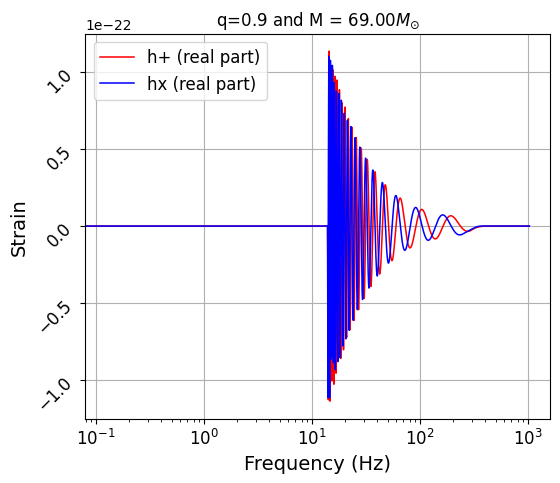

In [ ]:
# First operation: wavefrom approximant in radiation frame
hp, hc = waveform_polarizations_fd(approximant, obs_params)
indsum = np.where((hp.sample_frequencies>=fmin_sim)&(hp.sample_frequencies<=fmax_sim))

# Ensure at this point the waveforms have frequencies up to fmax_sim to avoid errors with get_cutoff_indices later
fmw = np.max(hp.sample_frequencies.numpy())
if fmw < fmax_sim:
  print("fmax sim pb detected")
  ds = int((fmax_sim - fmw)/delta_f) + 1
  hptemp = np.zeros((len(hp)+ds,))
  hctemp = np.zeros((len(hp)+ds,))
  hptemp[:len(hp)] = hp.data
  hctemp[:len(hp)] = hc.data
  hp = FrequencySeries(hptemp, delta_f = delta_f)
  hc = FrequencySeries(hctemp, delta_f = delta_f)

# Example Figure
plt.figure(figsize =(6,5))
plt.plot(hp.sample_frequencies, hp.data.real, label = "h+ (real part)", color = "red", linewidth = 1.1)
plt.plot(hc.sample_frequencies, hc.data.real, label = "hx (real part)", color = "blue", linewidth = 1.1)
plt.legend(fontsize = 12, loc = "upper left")
plt.xlabel("Frequency (Hz)", fontsize = 14)
plt.xscale("log")
plt.ylabel("Strain", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12, rotation = 45)
plt.title("q=%.1f and M = %.2f"%(q,M) +"$M_{\odot}$", loc = "center")
plt.grid()

3937
3937
complex128


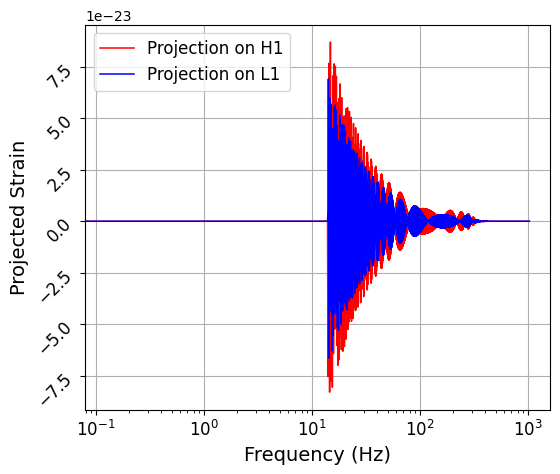

In [ ]:
# Second operation: project onto detectors
h = detector_frame_strain(hp, hc, my_detectors, det_params, verbose = False)
%matplotlib inline

# Plot the strains for illustration
ht1 = h[my_detectors[0]]
ht2 = h[my_detectors[1]]

# Check consistency of dimensions
print(len(ht1.sample_frequencies[indsum]))
print(int((fmax_sim-fmin_sim)/delta_f)+1)
print(ht1.dtype)

plt.figure(figsize =(6,5))
plt.plot(ht1.sample_frequencies, ht1.data.real, label = "Projection on %s"%my_detectors[0], color = "red", linewidth = 1.1)
plt.plot(ht2.sample_frequencies, ht2.data.real, label = "Projection on %s"%my_detectors[1], color = "blue", linewidth = 1.1)
plt.legend(fontsize = 12, loc = "upper left")
plt.xlabel("Frequency (Hz)", fontsize = 14)
plt.xscale("log")
plt.ylabel("Projected Strain", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12, rotation = 45)
plt.grid()

### Notes about summary size
- we cannot know in advance the size of the returned FrequencySeries, so we must crop the later in the simulator function
- given the typical size of the summary ($\sim 1000 - 10000$), an embedding net may constitute a good option for density estimation.

float64
15744
20.0
511.875


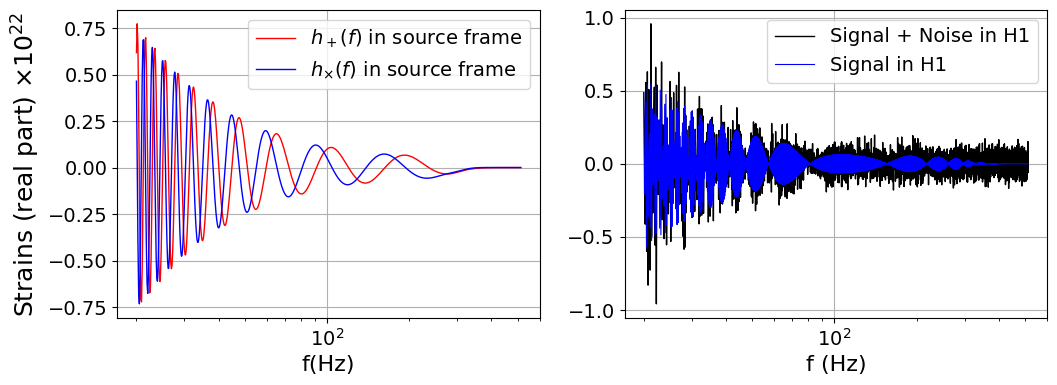

In [ ]:
# Rearange into an array and add noise for each detector
total_dim = sum([len(hd) for hd in h])
x0 = np.array([])
s0 = np.array([])

# We fix the seed to generate fake observation
seeds = [30, 33]
si = 0
for ifo in my_detectors:

  l = len(h[ifo])

  Nfftd = len(h[ifo])
  Nt = (Nfftd -1)*2
  # Use delta_f = Fs/Nt to get fmax (Nyquist-Shannon)
  #fmax = 0.5 * h[ifo].delta_f*Nt
  seed = seeds[si] ; si +=1
  np.random.seed(seed)
  psd_ifo = psd.from_string(psd_str, Nfftd, delta_f = delta_f, low_freq_cutoff = f_low_psd)
  f,s,n = inject_into_noise_fd(h[ifo], psd_ifo, fmin_sim, fmax_sim, tol = 1e-7)
  x0 = np.concatenate((x0, s.real + n.real, s.imag + n.imag))
  s0 = np.concatenate((s0, s.real , s.imag ))

x0 *= strain_scale
s0 *= strain_scale
print(x0.dtype)

# Having dim_x fixed and consistent is important!
dim_x = len(x0)
print(dim_x)
print(np.min(f.numpy()))
print(np.max(f.numpy()))
x_0_file = "x0_observation.npy"
np.save(sims_dir + "/" + x_0_file, x0)

lh = int(len(x0)/2)
lr = int(lh/2)
x1 = x0[:lh] ; x1r = x1[:lr]
x2 = x0[lh:] ; x2r = x2[:lr]
s1 = s0[:lh] ; s1r = s1[:lr]
s2 = s0[lh:] ; s2r = s2[:lr]

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[1].plot(f,x1r, color = "black", label = "Signal + Noise in %s"%my_detectors[0], linewidth = 1.0)
ax[1].grid()
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_xlabel("f (Hz)", fontsize = 16)


ax[1].plot(f,s1r, color = "blue", linestyle = "-",linewidth = 0.8, label = "Signal in %s"%my_detectors[0],  zorder = 2)
ax[1].set_xscale('log')
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].legend(fontsize = 14, loc = "best")

ax[0].plot(hp.sample_frequencies[indsum], hp.data.real[indsum]*strain_scale, color = "red", label = r"$h_+(f)$" + " in source frame", linewidth = 1.0)
ax[0].grid()
ax[0].legend(fontsize = 12, loc = "best")
ax[0].plot(hc.sample_frequencies[indsum], hc.data.real[indsum]*strain_scale, color = "blue", label = r"$h_{\times}(f)$" + " in source frame", linewidth = 1.0)
ax[0].set_xscale("log")
ax[0].set_ylabel("Strains (real part) " + r"$\times 10^{22} $", fontsize = 18)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_xlabel("f(Hz)", fontsize = 16)
ax[0].legend(fontsize = 14, loc = "best")

##1-4) Write simulator function for ILI
Rk: Cannot I pass other arguments rather than params for readability?

In [ ]:
# params[0] = luminosity distance
# params[1] = q = m2/m1 <=1  !!!
# params[2] = Mc = chirp mass
# params[3] = chi_eff
# params[4] = chi_a

def gw_simulator(params):

  if isinstance(params, torch.Tensor):
    params = params.cpu().numpy().flatten()

  # Waveform in source frame
  ms1, ms2 = McAndq_2_masses(params[2], params[1]) # careful of order
  obs_params["mass1"] = ms1
  obs_params["mass2"] = ms2
  obs_params["distance"] = params[0]

  # Spinz compoments, as in GWSim paper from chi_eff
  qt = ms2/ms1
  a = max([0.0,((1. + qt)*np.abs(params[3]) - 1.)/qt])
  b = min([1.0,((1. + qt)*np.abs(params[3]) + 1.)/qt])
  sp2z = np.random.uniform(low = a, high = b)
  sp1z = (1. + qt) * np.abs(params[3]) - qt * sp2z

  obs_params["spin1z"] = sp1z
  obs_params["spin2z"] = sp2z
  hp, hc = waveform_polarizations_fd(approximant, obs_params)

  # Ensure at this point the waveforms have frequencies up to fmax_sim to avoid errors with get_cutoff_indices later
  fmw = np.max(hp.sample_frequencies.numpy())
  if fmw < fmax_sim:
    print("fmax sim pb detected")
    ds = int((fmax_sim - fmw)/delta_f) + 1
    hptemp = np.zeros((len(hp)+ds,))
    hctemp = np.zeros((len(hp)+ds,))
    hptemp[:len(hp)] = hp.data
    hctemp[:len(hp)] = hc.data
    hp = FrequencySeries(hptemp, delta_f = delta_f)
    hc = FrequencySeries(hctemp, delta_f = delta_f)

  # Waveform (or "strain") projection in detector frame
  # There will be as many strains as detectors in the analysis
  h_proj = detector_frame_strain(hp, hc, my_detectors, det_params, verbose = False)

  # Rearange into an array and add noise for each detector
  total_dim = sum([len(hd) for hd in h_proj])
  x = np.array([])

  for ifo in my_detectors:

    l = len(h_proj[ifo])

    Nfftd = len(h_proj[ifo])
    Nt = (Nfftd -1)*2
    psd_ifo = psd.from_string(psd_str, Nfftd, delta_f = delta_f, low_freq_cutoff = f_low_psd)
    f,s,n = inject_into_noise_fd(h_proj[ifo], psd_ifo, fmin_sim, fmax_sim, tol = 1e-7)
    x = np.concatenate((x, s.real + n.real, s.imag + n.imag))

  dx = x.shape[0]
  temp = torch.from_numpy(x).to(dtype = torch.float32, device = device)
  # CAREFUL  the output shape is a `torch.Size((1,N))` (i.e, has a leading batch dimension 1)
  return torch.reshape(temp, (1,dx)) * strain_scale


In [ ]:
# Test the simulator function is running
xtest = gw_simulator([200,1.,40, 0.])
print(xtest.shape)
print(type(xtest))

torch.Size([1, 15744])
<class 'torch.Tensor'>


# 2) Setup prior

In [ ]:
# define a prior to sample parameters from
d_low = 100. ; d_high = 1000.
q_low = 0.2 ; q_high = 1.
chirp_low = 12. ; chirp_high = 45
chi_low = -1. ; chi_high = 1.
#phase_low = 0. ; phase_high = 2*np.pi
my_prior = ili.utils.Uniform(low=[d_low, q_low, chirp_low, chi_low],
                          high=[d_high, q_high, chirp_high, chi_high], device=device)

# # define a prior to sample parameters from
# d_low = 20. ; d_high = 1500.
# q_low = 0.1 ; q_high = 1.0
# chirp_low = 5. ; chirp_high = 60
# chi_low = -1. ; chi_high = 1.
# #phase_low = 0. ; phase_high = 2*np.pi
# my_prior = ili.utils.Uniform(low=[d_low, q_low, chirp_low, chi_low],
#                           high=[d_high, q_high, chirp_high, chi_high], device=device)

type(my_prior)

ili.utils.distributions_pt.IndependentUniform

# 3) Run ltu-ili density estimation

##3-1) Instantiate LOADER for multiround

In [ ]:
prerun_sims =False

if prerun_sims:
  x_file = "gw_sims_train_3d.npy"
  theta_file = "gw_params_train_3d.npy"
else:
  x_file =None
  theta_file = None
#SBISimulator?

# Additional number of sims to run at each round (round>1 if prerun sims)
n_sims_loader = 2000

# Observation x0 (for multiround inference)
x0test = np.load(sims_dir + "/" + x_0_file)

SBISimulator loader, because we will later try using a SBIRunnerSequential instance to have a multiround inference example

In [ ]:
my_loader = SBISimulator(in_dir = sims_dir, xobs_file = x_0_file,
                         num_simulations = n_sims_loader, simulator = gw_simulator,
                         x_file = x_file, theta_file = theta_file)

print(my_loader.__len__())

0


##3-2) Prior, embedding, models to train

In [ ]:
activation = "SiLU"
n_hidden = [200, 100, 16]
#n_hidden = [400,200, 100, 16]
n_summary = 50

# COMMENT BELOW TO ACTIVATE/DEACTIVATE EMBEDDING
my_embedding = FCN(n_hidden = n_hidden, act_fn = activation)
#my_embedding = None

# Example test from Matt
# from ili.embedding.fcn import CNN1DEmbedding
# my_embedding = CNN1DEmbedding(
#     n_filters=[8, 16, 32, 32],
#     kernel_sizes=[5, 5, 5, 5],
#     strides=[2, 2, 2, 2],
#     fc_hidden=n_hidden,
#     act_fn=activation,
# )

Prior values for masses similar as in [Green et. al, 2020](https://arxiv.org/pdf/2002.07656.pdf) for this example (section III-A)

RK 1801/2024: should better put priors on chirp mass and mass ratio, that's known to work better at least for likelihood based inference

In [ ]:
# define an inference class (here, we are doing amortized posterior inference)
inference_class = sbi.inference.SNPE # old API
engine = "SNPE" # 119-improve-api API

# Optional signatures (not used, for illustration here)
#signatures = ["maf_test", "mdn_test"]
signatures = ["maf_test"]

# For more details with eg MAF, check the function build_maf in sbi/sbi/neural_nets/flow.py
type_de = "maf" # Masked Autoregressive Flows
nHiddenMAF = 16 # default is 50
numT = 10 # number of stacked MADEs in the MAF, default is 5 if not specified
dropoutMAF = 0.0 # the high-level sbi interface set this to 0.0 by default
batchNorm = False# use_batch_norm = False by default in high-level sbi
activationType = torch.tanh # default of high-level sbi is torch.tanh for buld_maf

density_maf = sbi.utils.get_nn_models.posterior_nn(model = type_de, hidden_features = nHiddenMAF, num_transforms = numT,
                                           activation = activationType, dropout_probability = dropoutMAF, use_batch_norm = batchNorm)

# Here we specify a neural network for the MDN case
nHiddenMDN = 200 # default is 50
numComp = 10 # number of mixture components, 10 by default.
dropoutMDN = 0.2

# For more details on MDNs implementation, check sbi/sbi/neural_nets/mdn.py
# Be careful to use num_components and not num_transforms fro MDNs !
# In mdn.py, it uses the package pyknos, and features such as the activation functions (ReLU) and dropout rate (=0.0) are fixed
density_mdn= sbi.utils.get_nn_models.posterior_nn(model = "mdn", hidden_features = nHiddenMDN, num_components = numComp,
                                                 dropout_probability = dropoutMDN)

# instantiate your neural networks to be used as an ensemble
nets = [density_maf]
#nets = [density_maf, density_mdn]

# Training hyperparameters
my_val_fraction = 0.1
my_batch_size = 64
#my_batch_size = 32
my_learning_rate = 2e-5

# THERE FOR MULTIROUND
#nrounds = 6
nrounds = 5 #! multiround

# define training arguments: also "epochs",
train_args = {
    'training_batch_size': my_batch_size,
    'learning_rate': my_learning_rate,
    "validation_fraction": my_val_fraction,
    'num_round':nrounds,
}

my_output_path = './snpe'  # Where to save the posterior
if not os.path.exists(my_output_path):
  os.mkdir(my_output_path)

# initialize the trainer
runner = SBIRunnerSequential(
    prior=my_prior,
    engine= engine,
    nets=nets,
    device=device,
    embedding_net= my_embedding,
    train_args=train_args,
    proposal=None, # better keep to None
    out_dir=my_output_path,# no output path, so nothing will be saved to file
    signatures = signatures,
    name = "GW"
)



- To know about the simulator
 - the simulator should return a tensor of `torch.Size((1,p))`
 - in doubt, transfrom the simulator and prior with `simulator, prior = sbi.inference.prepare_for_sbi(simulator, prior)` (it seemed to work just fine when the simulator initially returned the wrong size)


In [ ]:
# train the model
posterior_ensemble, summaries = runner(loader=my_loader)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

(0,) (2000, 15744)
 Neural network successfully converged after 151 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

(2000, 15744) (2000, 15744)
Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

(4000, 15744) (2000, 15744)
Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

(6000, 15744) (2000, 15744)
Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

(8000, 15744) (2000, 15744)
Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

#4) Validation metrics

In [ ]:
print(my_embedding) # test

FCN(
  (act_fn): SiLU()
  (mlp): Sequential(
    (mlp0): Linear(in_features=15744, out_features=200, bias=True)
    (act0): SiLU()
    (mlp1): Linear(in_features=200, out_features=100, bias=True)
    (act1): SiLU()
    (mlp2): Linear(in_features=100, out_features=16, bias=True)
  )
)


In [ ]:
## Ensemble mode choice if we trained more than one model
ensemble_mode = False
my_backend = "sbi"
my_labels = paramStr

##4-1) Plot log-probability and posterior on fake observation


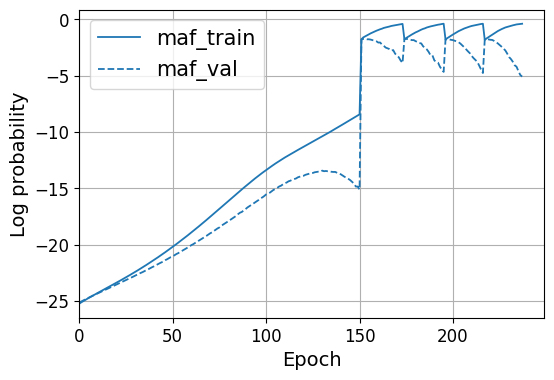

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
min_e = 0
max_e = -1
for i, m in enumerate(summaries):
    # ax.plot(m['training_log_probs'][min_e:max_e], ls='-', label=f"{i}_train", c=c[i], linewidth = 1.2)
    # ax.plot(m['validation_log_probs'][min_e:max_e], ls='--', label=f"{i}_val", c=c[i], linewidth = 1.2)
    ax.plot(m['training_log_probs'][min_e:max_e], ls='-', label="maf_train", c=c[i], linewidth = 1.3)
    ax.plot(m['validation_log_probs'][min_e:max_e], ls='--', label="maf_val", c=c[i], linewidth = 1.3)
ax.set_xlim(0)
ax.set_xlabel('Epoch', fontsize = 14)
ax.set_ylabel('Log probability', fontsize = 14)
ax.tick_params(axis = "both", which = "major", labelsize = 12)
ax.grid()
ax.legend(fontsize = 15)

In [ ]:
posterior_ensemble.posteriors
print(paramStr)
theta_obs

['$d_L$', '$q$', '$\\mathcal{M}$', '$\\chi_{eff}$']


array([400.        ,   0.86486486,  29.93926975,   0.43594203])

For plots, use only posterior_ensemple.posteriors[i] to look at individual posterior indexed i (from nets[i]), even if ensemble_mode = False.



In [ ]:
theta_obs

array([400.        ,   0.86486486,  29.93926975,   0.43594203])

In [ ]:
metric2 = PosteriorSamples( out_dir=None, num_samples=20000,
    sample_method='direct', labels=paramStr)

samples = metric2( posterior=posterior_ensemble, x = np.array([[x0test],]), theta=np.array([theta_obs,]))
print(samples.shape)
np.save("precious_posterior_smaples.npy", samples)

100%|██████████| 1/1 [00:18<00:00, 18.90s/it]

(20000, 1, 4)


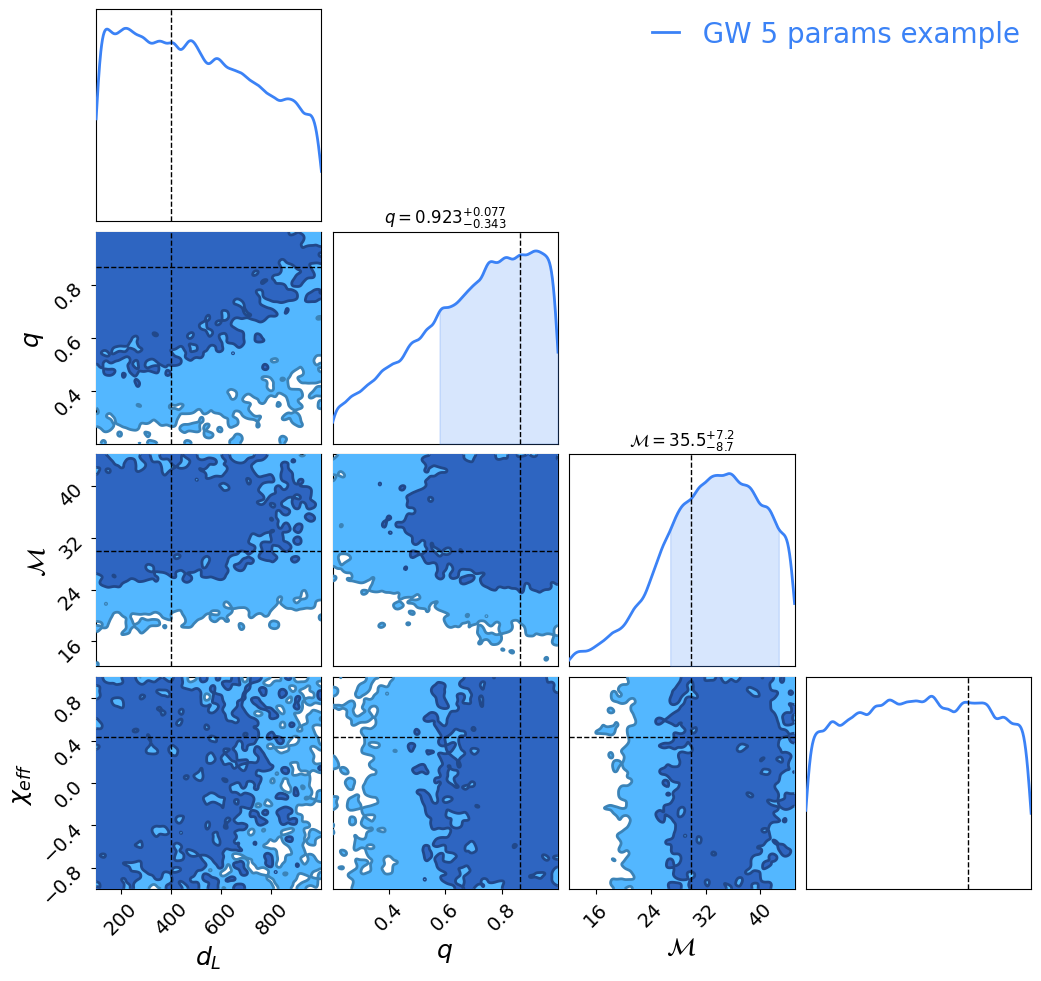

In [ ]:
df = pd.DataFrame({paramStr[0]:samples[:,0,0], paramStr[1]:samples[:,0,1] , paramStr[2]:samples[:,0,2],
           paramStr[3]:samples[:,0,3]})

# kde = 0.0
c= ChainConsumer()
my_chain = Chain(
    samples=df,
    name="GW 5 params example",
    color="blue",
    plot_point=False,
    plot_cloud=False,
    marker_style="*",
    marker_size=100,
    # num_cloud=10000,
    shade=True,
    linewidth=2.0,
    smooth = 10., # default 3
    # cmap="magma",
    show_contour_labels=False,
    # kde = kde
)
#my_chain = Chain(samples = df, name  = "dumb")
c.add_chain(my_chain)

c.add_truth(Truth(location={paramStr[0]: theta_obs[0], paramStr[1]: q_obs, paramStr[2]:Mc_obs, paramStr[3]:theta_obs[3]}))
c.set_plot_config(
    PlotConfig(
        flip=True,
        contour_label_font_size=12,
        tick_font_size = 14,
        label_font_size = 18,
        show_legend = True,
        legend_kwargs = {"fontsize":20},
        diagonal_tick_labels = True
    ))
fig = c.plotter.plot()
plt.savefig("gw_corner_1.pdf")

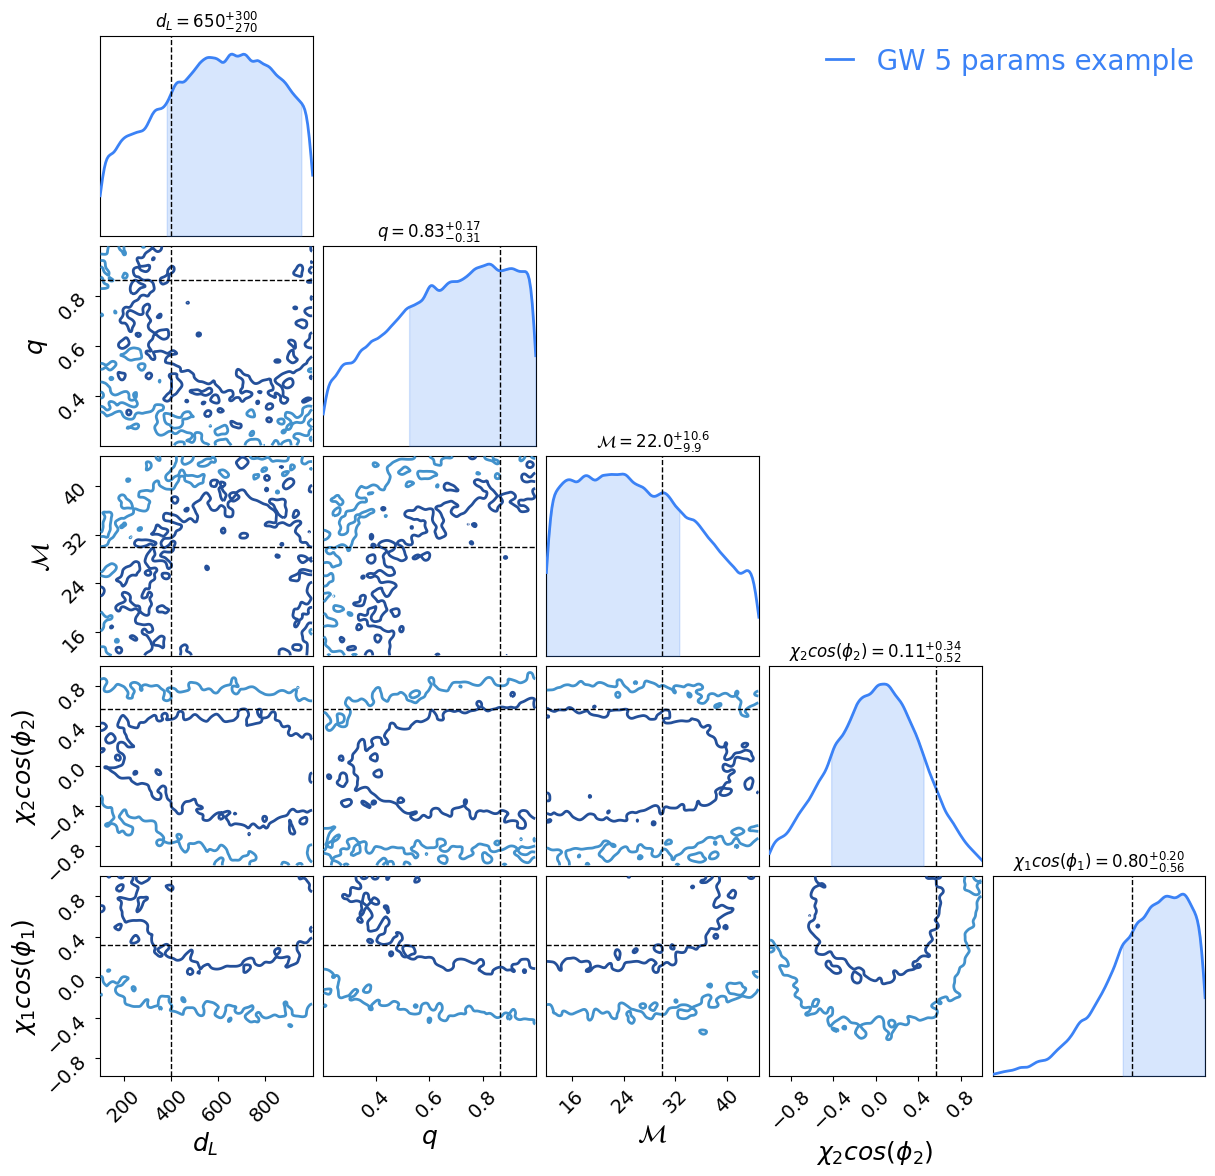

In [ ]:
df = pd.DataFrame({paramStr[0]:samples[:,0,0], paramStr[1]:samples[:,0,1] , paramStr[2]:samples[:,0,2],
           paramStr[4]:samples[:,0,4], paramStr[3]:samples[:,0,3]})

kde = 0.0
c= ChainConsumer()
my_chain = Chain(
    samples=df + kde,
    name="GW 5 params example",
    color="blue",
    plot_point=False,
    plot_cloud=False,
    marker_style="*",
    marker_size=100,
    num_cloud=10000,
    shade=False,
    linewidth=2.0,
    cmap="magma",
    show_contour_labels=False,
    kde = kde
)
#my_chain = Chain(samples = df, name  = "dumb")
c.add_chain(my_chain)
c.add_truth(Truth(location={paramStr[0]: theta_obs[0], paramStr[1]: q_obs, paramStr[2]:Mc_obs, paramStr[4]:theta_obs[4], paramStr[3]:theta_obs[3]}))
c.set_plot_config(
    PlotConfig(
        flip=True,
        contour_label_font_size=12,
        tick_font_size = 14,
        label_font_size = 18,
        show_legend = True,
        legend_kwargs = {"fontsize":20},
        diagonal_tick_labels = True
    ))
fig = c.plotter.plot()
plt.savefig("gw_corner_2.pdf")

In [ ]:
Chain?

In [ ]:
tt = make_sample()
tt

##4-2) (TODO) SAMPLE-BASED METRICS

In [ ]:
# The integer below includes the test simulations
# for sample-based metrics later
n_test_sims = 1000
test_params = my_prior.sample(sample_shape = (n_test_sims,))
print(test_params.shape)
#print(test.cpu().numpy())
params_bank = test_params.cpu().numpy()
print(params_bank.shape)
np.savetxt(sims_dir + "/gw_params_3d.txt", params_bank)

sims_bank = np.zeros((dim_x,n_test_sims))

pbar = progressbar.ProgressBar(max_value=n_test_sims)
for n in range(n_test_sims):
  xsim = gw_simulator(params_bank[n,:])
  sims_bank[:,n] = xsim.cpu().numpy().reshape((dim_x,))
  pbar.update(n)

np.save(sims_dir + "/gw_sims_3d.npy", sims_bank)

In [ ]:
# Drawing samples from the ensemble posterior

metric3 = PosteriorCoverage( out_dir=None, num_samples=1000,
    sample_method='direct', labels=paramStr,
    plot_list = ["tarp"])
print(metric3.plot_list)

fig3 = metric3(posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x = sims_bank.T, theta= params_bank.T)

